# Projeto Redes Neurais 
Integrantes:Diogo Shiroto
            Hugo Leonardo
            Sheyla Lima
            Lucas Amorim

**Importações**

In [32]:
import numpy as np
from sklearn import metrics
import pandas as pd
from keras import optimizers
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.metrics import roc_auc_score, average_precision_score, mean_squared_log_error
import scikitplot as skplt
import matplotlib
import matplotlib.pyplot as plt

In [33]:
data_set = pd.read_table('TRN')
#data_set.drop_duplicates(inplace=True)  # Remove exemplos repetidos

In [34]:
data_set.describe()

,INDEX,UF_1,UF_2,UF_3,UF_4,UF_5,UF_6,UF_7,IDADE,SEXO_1,...,CEP4_7,CEP4_8,CEP4_9,CEP4_10,CEP4_11,CEP4_12,CEP4_13,CEP4_14,IND_BOM_1_1,IND_BOM_1_2
count,389196.00000,389196.000000,389196.000000,389196.000000,389196.000000,389196.000000,389196.000000,389196.000000,3.891960e+05,389196.000000,...,389196.000000,389196.000000,389196.000000,389196.000000,389196.000000,389196.000000,389196.000000,389196.000000,389196.000000,389196.000000
mean,194597.50000,0.889274,0.691952,0.476552,0.296195,0.241179,0.218011,0.186836,4.552049e-01,0.521514,...,0.423378,0.417540,0.425708,0.459820,0.440842,0.436896,0.433709,0.440339,0.655449,0.344551
std,112351.35202,0.313793,0.461687,0.499451,0.456579,0.427799,0.412895,0.389781,2.537459e-01,0.499538,...,0.494095,0.493154,0.494451,0.498384,0.496489,0.496002,0.495587,0.496428,0.475222,0.475222
min,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.506237e-16,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,97298.75000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.507866e-01,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,194597.50000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.375241e-01,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,291896.25000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,6.578835e-01,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
max,389195.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000e+00,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [35]:
data_set.head()

,INDEX,UF_1,UF_2,UF_3,UF_4,UF_5,UF_6,UF_7,IDADE,SEXO_1,...,CEP4_7,CEP4_8,CEP4_9,CEP4_10,CEP4_11,CEP4_12,CEP4_13,CEP4_14,IND_BOM_1_1,IND_BOM_1_2
0,0,1,1,1,0,0,0,0,0.135098,1,...,0,0,1,1,0,1,1,1,0,1
1,1,1,0,1,0,0,1,0,0.273504,1,...,0,1,0,1,1,0,0,0,1,0
2,2,1,0,1,0,0,1,0,0.281910,0,...,1,1,0,0,0,0,1,0,1,0
3,3,1,1,1,0,0,0,0,0.225741,0,...,1,1,0,1,1,0,1,0,1,0
4,4,1,1,0,0,0,1,0,0.480403,0,...,1,1,1,0,0,1,0,1,1,0


In [36]:
#Segura em DataFrame ainda param mais na frente fazer o Sampling
X = data_set.iloc[:,1:-2]
y = data_set.iloc[:,-2:-1]


In [37]:
## Treino: 50%, Validação: 25%, Teste: 25%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1/4, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=1/3, random_state=42, stratify=y_train)

In [38]:
#Replicando a classe minoritária para os conjuntos de Treinamento e Validação
X_train = pd.concat((X_train,y_train),axis=1) #concatena a coluna a direita
X_train_c0 = X_train.loc[X_train.IND_BOM_1_1 == 0]
X_train_c1 = X_train.loc[X_train.IND_BOM_1_1 == 1]

#Sampling no Conjunto de Treinamento de C2
c0_train = X_train_c0.sample(n = X_train_c1.IND_BOM_1_1.count(),random_state = 1,replace = True)
#Previsores Classe 1 + Previsores Classe 2
X_train = X_train_c1.append(c0_train).reset_index(drop=True)
#Embaralhando os registros
X_train = X_train.sample(frac=1).reset_index(drop=True)

#Separando em Previsores e Classes
y_train = X_train.iloc[:,-1].values
X_train = X_train.iloc[:,0:-1].values



#VALIDAÇÃO
X_val = pd.concat((X_val,y_val),axis=1) #concatena a coluna a direita
X_val_c0 = X_val.loc[X_val.IND_BOM_1_1 == 0]
X_val_c1 = X_val.loc[X_val.IND_BOM_1_1 == 1]

#Sampling no Conjunto de Treinamento de C2
c0_val = X_val_c0.sample(n = X_val_c1.IND_BOM_1_1.count(),random_state = 1,replace = True)
#Previsores Classe 1 + Previsores Classe 2
X_val = X_val_c1.append(c0_val).reset_index(drop=True)
#Embaralhando os registros
X_val = X_val.sample(frac=1).reset_index(drop=True)

#Separando em Previsores e Classes
y_val = X_val.iloc[:,-1].values
X_val = X_val.iloc[:,0:-1].values


In [39]:
#Escalonamento das variáveis
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test.values)


# Montagem da rede MLP

In [40]:
# Número de features do nosso data set.
input_dim = X_train.shape[1]

# Aqui criamos o esboço da rede.
classifier = Sequential()

classifier.add(Dense(64, activation='tanh', input_dim=input_dim))
classifier.add(Dense(32, activation='relu'))
classifier.add(Dense(32, activation='sigmoid'))
classifier.add(Dense(32, activation='softmax'))
classifier.add(Dense(1, activation='sigmoid'))

# Por fim compilamos o modelo especificando um otimizador, a função de custo, e opcionalmente
# métricas para serem observadas durante treinamento.
sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
classifier.compile(optimizer='sgd', loss='mean_squared_error')

# Para treinar a rede passamos o conjunto de treinamento e especificamos o tamanho do mini-batch,
# o número máximo de épocas, e opcionalmente callbacks. No seguinte exemplo utilizamos early
# stopping para interromper o treinamento caso a performance não melhore em um conjunto de validação.
history = classifier.fit(X_train, y_train, batch_size=64, epochs=60, 
                         callbacks=[EarlyStopping(patience=3)], validation_data=(X_val, y_val))

Train on 255098 samples, validate on 127550 samples
Epoch 1/60
255098/255098 [==============================] - 11s 43us/step - loss: 0.2501 - val_loss: 0.2500
Epoch 2/60
255098/255098 [==============================] - 10s 38us/step - loss: 0.2500 - val_loss: 0.2500
Epoch 3/60
255098/255098 [==============================] - 10s 38us/step - loss: 0.2500 - val_loss: 0.2500
Epoch 4/60
255098/255098 [==============================] - 10s 38us/step - loss: 0.2500 - val_loss: 0.2500
Epoch 5/60
255098/255098 [==============================] - 10s 39us/step - loss: 0.2500 - val_loss: 0.2500
Epoch 6/60
255098/255098 [==============================] - 10s 39us/step - loss: 0.2499 - val_loss: 0.2499
Epoch 7/60
255098/255098 [==============================] - 10s 39us/step - loss: 0.2499 - val_loss: 0.2499
Epoch 8/60
255098/255098 [==============================] - 10s 39us/step - loss: 0.2499 - val_loss: 0.2499
Epoch 9/60
255098/255098 [==============================] - 10s 39us/step - loss: 0.

In [41]:
def extract_final_losses(history):
    """Função para extrair o melhor loss de treino e validação.
    
    Argumento(s):
    history -- Objeto retornado pela função fit do keras.
    
    Retorno:
    Dicionário contendo o melhor loss de treino e de validação baseado 
    no menor loss de validação.
    """
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    idx_min_val_loss = np.argmin(val_loss)
    return {'train_loss': train_loss[idx_min_val_loss], 'val_loss': val_loss[idx_min_val_loss]}

def plot_training_error_curves(history):
    """Função para plotar as curvas de erro do treinamento da rede neural.
    
    Argumento(s):
    history -- Objeto retornado pela função fit do keras.
    
    Retorno:
    A função gera o gráfico do treino da rede e retorna None.
    """
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    fig, ax = plt.subplots()
    ax.plot(train_loss, label='Train')
    ax.plot(val_loss, label='Validation')
    ax.set(title='Training and Validation Error Curves', xlabel='Epochs', ylabel='Loss (MSE)')
    ax.legend()
    plt.show()

def compute_performance_metrics(y, y_pred_class, y_pred_scores=None):
    accuracy = accuracy_score(y, y_pred_class)
    recall = recall_score(y, y_pred_class)
    precision = precision_score(y, y_pred_class)
    f1 = f1_score(y, y_pred_class)
    performance_metrics = (accuracy, recall, precision, f1)
    if y_pred_scores is not None:
        skplt.metrics.plot_ks_statistic(y, y_pred_scores)
        plt.show()
        y_pred_scores = y_pred_scores[:, 1]
        auroc = roc_auc_score(y, y_pred_scores)
        aupr = average_precision_score(y, y_pred_scores)
        performance_metrics = performance_metrics + (auroc, aupr)
    return performance_metrics

def print_metrics_summary(accuracy, recall, precision, f1, auroc=None, aupr=None):
    print()
    print("{metric:<18}{value:.4f}".format(metric="Accuracy:", value=accuracy))
    print("{metric:<18}{value:.4f}".format(metric="Recall:", value=recall))
    print("{metric:<18}{value:.4f}".format(metric="Precision:", value=precision))
    print("{metric:<18}{value:.4f}".format(metric="F1:", value=f1))
    if auroc is not None:
        print("{metric:<18}{value:.4f}".format(metric="AUROC:", value=auroc))
    if aupr is not None:
        print("{metric:<18}{value:.4f}".format(metric="AUPR:", value=aupr))

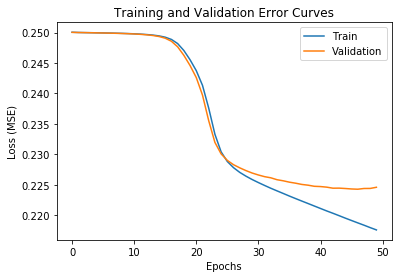

In [42]:
plot_training_error_curves(history)

Matriz de confusão no conjunto de teste:
[[21497 12028]
 [23770 40004]]

Train Loss:       0.2187
Validation Loss:  0.2243

Performance no conjunto de teste:


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


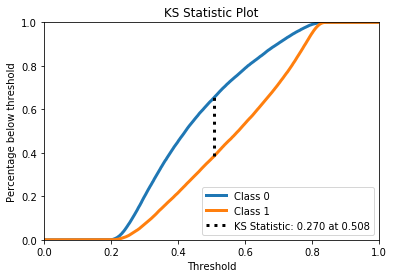


Accuracy:         0.6321
Recall:           0.6273
Precision:        0.7688
F1:               0.6909
AUROC:            0.6856
AUPR:             0.7972


In [43]:
# Fazer predições no conjunto de teste
y_pred_scores = classifier.predict(X_test)
y_pred_class = classifier.predict_classes(X_test, verbose=0)
y_pred_scores_0 = 1 - y_pred_scores
y_pred_scores = np.concatenate([y_pred_scores_0, y_pred_scores], axis=1)

## Matriz de confusão
print('Matriz de confusão no conjunto de teste:')
print(confusion_matrix(y_test, y_pred_class))

## Resumo dos resultados
losses = extract_final_losses(history)
print()
print("{metric:<18}{value:.4f}".format(metric="Train Loss:", value=losses['train_loss']))
print("{metric:<18}{value:.4f}".format(metric="Validation Loss:", value=losses['val_loss']))
print('\nPerformance no conjunto de teste:')
accuracy, recall, precision, f1, auroc, aupr = compute_performance_metrics(y_test, y_pred_class, y_pred_scores)
print_metrics_summary(accuracy, recall, precision, f1, auroc, aupr)